# Simple Bayesian Modeling

Here we'll apply what we learned in the previous section, and use Python to fit some Bayesian models.
We'll start with the classic model fitting problem: **Fitting a line to data**.

We'll begin with some standard Python imports:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set() # for plot formatting

C:\Anaconda3.2.4\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## The Data

For the sake of this demonstration, let's start by creating some data that we will fit with a straight line:

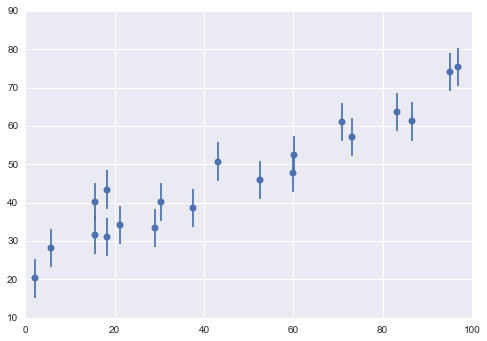

In [5]:
def make_data(intercept, slope, N=20, dy=5, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += dy * rand.randn(N)
    return x, y, dy * np.ones_like(x)

theta_true = [25, 0.5]
x, y, dy = make_data(*theta_true)
plt.errorbar(x, y, dy, fmt='o');

## The Model

Next we need to specify a model. We're fitting a straight line to data, so we'll need a slope and an intercept; i.e.

$$
y_M(x) = mx + b
$$

where our paramteter vector might be 

$$
\theta = [b, m]
$$

But this is only half the picture: what we mean by a "model" in a Bayesian sense is not only this expected value $y_M(x;\theta)$, but a **probability distribution** for our data.
That is, we need an expression to compute the likelihood $P(D\mid\theta)$ for our data as a function of the parameters $\theta$.

Here we are given data with simple errorbars, which imply that the probability for any *single* data point is a normal distribution about the true value. That is,

$$
y_i \sim \mathcal{N}(y_M(x_i;\theta), \sigma)
$$

or, in other words,

$$
P(x_i,y_i\mid\theta) = \frac{1}{\sqrt{2\pi\varepsilon_i^2}} \exp\left(\frac{-\left[y_i - y_M(x_i;\theta)\right]^2}{2\varepsilon_i^2}\right)
$$

where $\varepsilon_i$ are the (known) measurement errorsindicated by the errorbars.

Assuming all the points are independent, we can find the full likelihood by multiplying the individual likelihoods together:

$$
P(D\mid\theta) = \prod_{i=1}^N P(x_i,y_i\mid\theta)
$$

For convenience (and also for numerical accuracy) this is often expressed in terms of the log-likelihood:

$$
\log P(D\mid\theta) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\varepsilon_i^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\varepsilon_i^2}\right)
$$

### Quick Exercise

1. Write a Python function which computes the log-likelihood given a parameter vector $\theta$, an array of errors $\varepsilon$, and an array of $x$ and $y$ values

2. Use tools in [``scipy.optimize``](http://docs.scipy.org/doc/scipy/reference/optimize.html) to maximize this likelihood (i.e. minimize the negative log-likelihood). How close is this result to the input ``theta_true`` above?

In [6]:
# Write your code here

See the [Solutions-02](Solutions-02.ipynb#Quick-Exercise) notebook for one possible approach.

## The Prior

We have computed the likelihood, now we need to think about the prior $P(\theta\mid I)$.

This is where Bayesianism gets a bit controversial... what can we actually say about the slope and intercept before we fit our data?

There are a couple approaches to choosing priors that you'll come across in practice:

### 0. Conjugate Priors

In the days before computational power caught up with the aspirations of Bayesians, it was important to choose priors which would make the posterior analytically computable. A [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) is a prior which, due to its mathematical relation to the likelihood, makes the result analytically computable.
The problem is that the form of the conjugate prior is very rarely defensible on any grounds other than computational convenience, and so this is **almost never a good choice**.
You'll still occasionally hear people attack Bayesian approaches because of the use of conjugate priors: these people's arguments are decades outdated, and you should treat them appropriately.

### 1. Empirical Priors

Empirical Priors are priors which are actually posteriors from previous studies of the same phenomenon. For example, it's common in Supernova cosmology studies to use the WMAP results as a prior: that is, we actually plug-in a *real result* and use our new data to improve on that. This situation is where Bayesian approaches really shine.

For our linear fit, you might imagine that our $x, y$ data is a more accurate version of a previous experiment, where we've found that the intercept is $\theta_0 = 50 \pm 30$ and the slope is $\theta_1 = 1.0 \pm 0.5$.
In this case, we'd encode this prior knowledge in the prior distribution itself.

### 2. Flat Priors

If you don't have an empirical prior, you might be tempted to simply use a *flat prior* – i.e. a prior that is constant between two reasonable limits (i.e. equal probability slopes from -1000 to +1000).

The problem is that flat priors are not always non-informative! For example, a flat prior on the slope will effectively give a higher weight to larger slopes.
We can see this straightforwardly by plotting regularly-spaced slopes between 0 and 20:

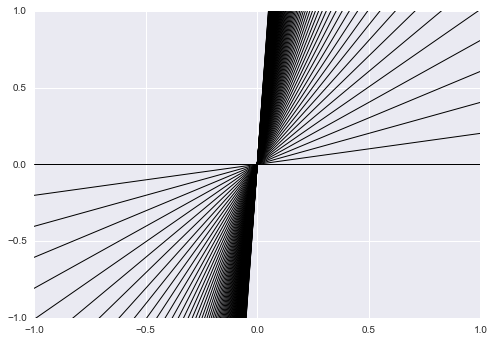

In [7]:
xx = np.linspace(-1, 1)
for slope in np.linspace(0, 20, 100):
    plt.plot(xx, slope * xx, '-k', linewidth=1)
plt.axis([-1, 1, -1, 1], aspect='equal');

The density of the lines is a proxy for the probability of those slopes with a flat prior.
This is an important point to realize: **flat priors are not necessarily minimally informative**.

### 3. Non-informative Priors

What we *really* want in cases where no empirical prior is available is a **non-informative prior**. Among other things, such a prior should not depend on the units of the data.
Perhaps the most principled approach to choosing non-informative priors was the *principle of maximum entropy* advocated by Jaynes ([book](http://omega.albany.edu:8008/JaynesBook.html)).

Similar in spirit is the commonly-used [Jeffreys Prior](https://en.wikipedia.org/wiki/Jeffreys_prior), which in many cases of interest amounts to a "scale invariant" prior: a flat prior on the logarithm of the parameter.

In the case of the linear slope, we often want a prior which does not artificially over-weight large slopes: there are a couple possible approaches to this (see http://arxiv.org/abs/1411.5018 for some discussion). For our situation, we might use a flat prior on the angle the line makes with the x-axis, which gives

$$
P(m) \propto (1 + m^2)^{-3/2}
$$

For lack of a better term, I like to call this a "symmetric prior" on the slope (because it's the same whether we're fitting $y = mx + b$ or $x = m^\prime y + b^\prime$).

### Implementation

Let's define two python functions to compute the options for our prior: we'll use both a (log) flat prior and a (log) symmetric prior.
In general, we need not worry about the normalization of the prior or the likelihood, which makes our lives easier:

In [8]:
def log_flat_prior(theta):
    if np.all(np.abs(theta) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_symmetric_prior(theta):
    if np.abs(theta[0]) < 1000:
        return -1.5 * np.log(1 + theta[1] ** 2)
    else:
        return -np.inf  # log(0)

With these defined, we now have what we need to compute the log posterior as a function of the model parameters.
You might be tempted to maximize this posterior in the same way that we did with the likelihood above, but this is not a Bayesian result! The Bayesian result is a (possibly marginalized) posterior probability for our parameters.
The mode of a probability distribution is perhaps slightly informative, but it is in no way a Bayesian result.

In the breakout, we will take a few minutes now to plot the posterior probability as a function of the slope and intercept.

## Breakout

1. Using matplotlib, plot the posterior probability distribution for the slope and intercept, once for each prior. I would suggest using ``plt.contourf()`` or ``plt.pcolor()``. How different are the distributions?

2. Modify the dataset – how do the results change if you have very few data points or very large errors?

3. If you finish this quickly, try adding 1-sigma and 2-sigma contours to your plot, keeping in mind that the probabilities are not normalized! You can add them to your plot with ``plt.contour()``.

In [9]:
# Write your code here

See the [Solutions-02](Solutions-02.ipynb#Breakout) notebook for one possible approach to answering these questions. But give this a good try before simply clicking! It's by working through this yourself that you will really learn the material.